In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize

In [2]:
game_count = pd.read_csv('game_counts.csv')
ROI_data = pd.read_csv('ROI_Additional_Data.csv')
park_data = pd.read_csv('PARK_Additional_Data.csv')

In [3]:
game_count.head()

,Year,Day,Time,Elephant,Buffalo,Eland,Zebra,Waterbuck,Kudu,Impala,Nyala,Bushbuck,Wild dog,Lion,Leopard,Hyena,Jackal,Warthog,Baboon
0,1995,Saturday,am,155,381,179,460,234,66,3005,0,3,10,4,0,30.0,12,154,831.0
1,1995,Saturday,pm,211,634,209,416,248,105,2345,0,2,0,4,0,5.0,4,190,455.0
2,1995,Sunday,am,159,465,136,426,238,62,2376,0,3,30,3,0,14.0,6,112,500.0
3,1995,Sunday,pm,173,304,171,581,242,140,2131,0,2,0,7,0,3.0,2,138,397.0
4,1996,Saturday,am,210,376,173,273,350,54,4099,0,0,21,1,0,2.0,0,87,NaN


In [4]:
ROI_data.head()

,date,aet,def,pdsi,pet,pr,ro,soil,srad,swe,tmmn,tmmx,vap,vpd,vs,NDVI,EVI,water
0,1994-01-01,1271.115655,0.000000,-176.444517,1271.115655,225.103465,11.018715,1146.696161,1967.839371,0,218.973337,313.538669,2543.985543,107.698692,179.439579,0.0,0.0,0.000000
1,1994-02-01,1179.904839,8.187955,-219.803671,1188.027883,124.614565,6.019286,1150.920719,2091.790276,0,211.425720,314.195116,2556.945691,101.277126,200.117931,0.0,0.0,0.620240
2,1994-03-01,543.708830,1072.130230,-328.451039,1615.981008,20.136859,1.000000,798.663319,2699.379822,0,200.084897,341.478933,2524.916770,134.850740,179.715429,0.0,0.0,0.000000
3,1994-04-01,371.896460,1089.503726,-396.650850,1461.404089,20.160835,1.000000,619.774164,2372.632383,0,184.954262,335.683922,2128.735675,155.116642,233.469610,0.0,0.0,1.125518
4,1994-05-01,110.845571,1145.726506,-446.846716,1256.321931,0.000000,0.000000,509.156497,2164.113713,0,149.225519,317.370164,1703.777281,150.488028,192.711932,0.0,0.0,0.000000


In [5]:
park_data.head()

,date,aet,def,pdsi,pet,pr,ro,soil,srad,swe,tmmn,tmmx,vap,vpd,vs,NDVI,EVI,water
0,1994-01-01,1267.006402,0.000000,-172.092319,1267.006402,230.408492,11.456392,1180.228072,2017.244606,0,209.993725,301.971014,2442.072311,96.894962,194.197176,0.0,0.0,0.000000
1,1994-02-01,1161.704833,4.015973,-222.765093,1165.725675,130.146433,6.572912,1254.841728,2122.011775,0,201.078728,302.841872,2458.281608,89.687915,209.121868,0.0,0.0,0.864484
2,1994-03-01,706.398521,862.470994,-329.802243,1568.828266,27.194653,1.317929,806.592258,2699.509342,0,189.628516,328.817675,2419.573520,120.104349,184.017749,0.0,0.0,0.000000
3,1994-04-01,427.878513,962.530063,-399.254767,1390.376969,23.104885,1.000000,598.201121,2355.336242,0,173.271879,321.061026,2035.397771,137.099800,232.991837,0.0,0.0,1.007595
4,1994-05-01,118.879492,1086.980407,-457.549385,1205.852421,0.000000,0.000000,480.003022,2153.241753,0,139.130771,303.458604,1625.108680,135.382152,194.255046,0.0,0.0,0.000000


Analysing climatic conditions on the park alongside area of interest.

In [6]:
park_data=park_data.rename(columns={"def":"water_def"})
ROI_data=ROI_data.rename(columns={"def":"water_def"})
game_count=game_count.rename(columns={"Wild dog":"Wild_dog"})

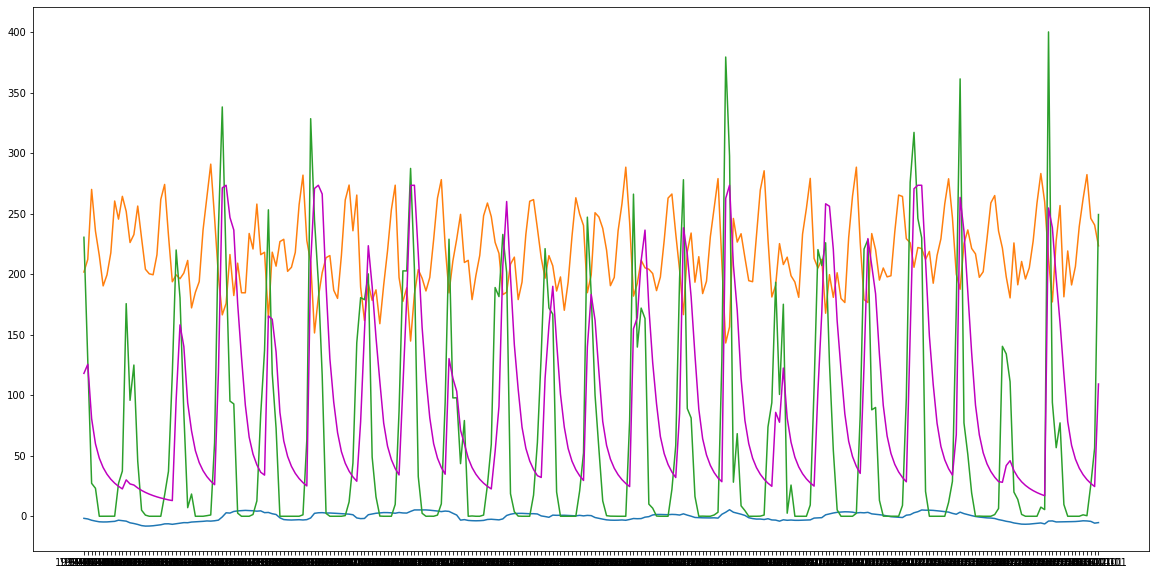

In [7]:
plt.figure(figsize=(20,10))
plt.plot(park_data.date, park_data.pdsi * 0.01,label='Some Draught Index')
plt.plot(park_data.date, park_data.srad * 0.1, label="Short Wave Radiation")
plt.plot(park_data.date, park_data.pr, label="Precipitation Accumulation")
plt.plot(park_data.date, park_data.soil * 0.1,'m', label="Soil moisture")

### Using Moving Average to Check for any Climatic Trends

We used moving average(s) to analyse any underlying climatic trends, be it shortwave radiation and soil mosture. All factors did not show significant variance over the period of time the data was collected. It can therefore be concluded that the animal sightings were not a function of climatic changes.  

In [43]:
dates = np.array(park_data.date)
def moving_average(park_series,ROI_series,title,window, plot_intervals = False, scale = 1.96):
    ROI_rolling_mean = ROI_series.rolling(window=window).mean()
    park_rolling_mean = park_series.rolling(window=window).mean()
    plt.figure(figsize=(17,8))
    plt.title(title + "\n window size = {}".format(window))
    plt.plot(dates,ROI_rolling_mean, label='Rolling mean trend')
    plt.plot(dates,park_rolling_mean, label='park mean trend')    
    
    if plot_intervals:
        park_mae = mean_absolute_error(park_series[window:], park_rolling_mean[window:])
        ROI_mae = mean_absolute_error(ROI_series[window:], ROI_rolling_mean[window:])
        park_deviation = np.std(park_series[window:] - park_rolling_mean[window:])
        ROI_deviation = np.std(ROI_series[window:] - ROI_rolling_mean[window:])
        park_lower_bound = rolling_mean - (mae + scale * deviation)
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        park_lower_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(dates, upper_bound, 'r--', label ='ROI Upper bound/ Lower Bound')
        plt.plot(dates, lower_bound, 'r--')
        plt.plot(dates, park_upper_bound, 'r--', label ='park Upper bound/ Lower Bound')
        plt.plot(dates, park_lower_bound, 'r--')
    
    plt.plot(park_series[window:], label='Actual Values' )
    plt.plot(ROI_series[window:], label='ROI Actual Values' )
    plt.legend(loc='best')
    

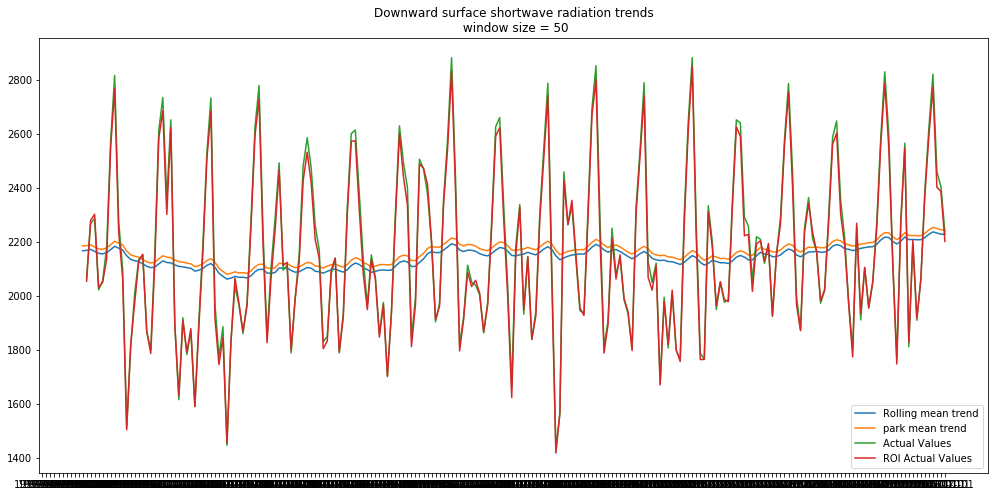

In [45]:
moving_average(park_data.srad,ROI_data.srad,"Downward surface shortwave radiation trends",50)

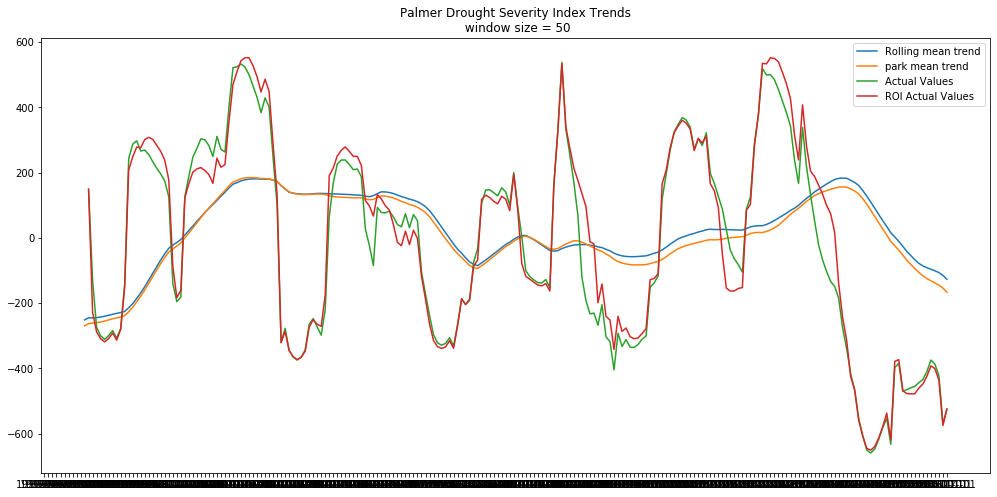

In [46]:
moving_average(park_data.pdsi,ROI_data.pdsi,"Palmer Drought Severity Index Trends",50)

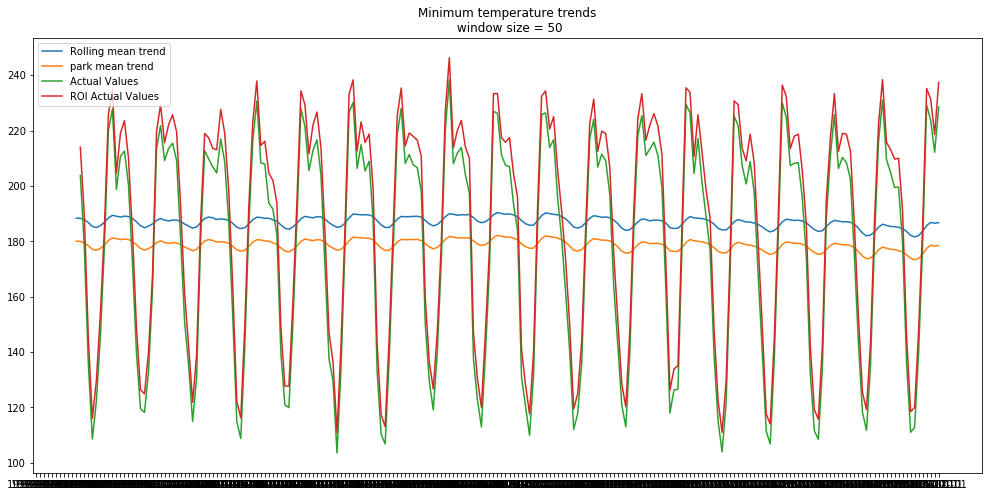

In [47]:
moving_average(park_data.tmmn,ROI_data.tmmn,"Minimum temperature trends",50)

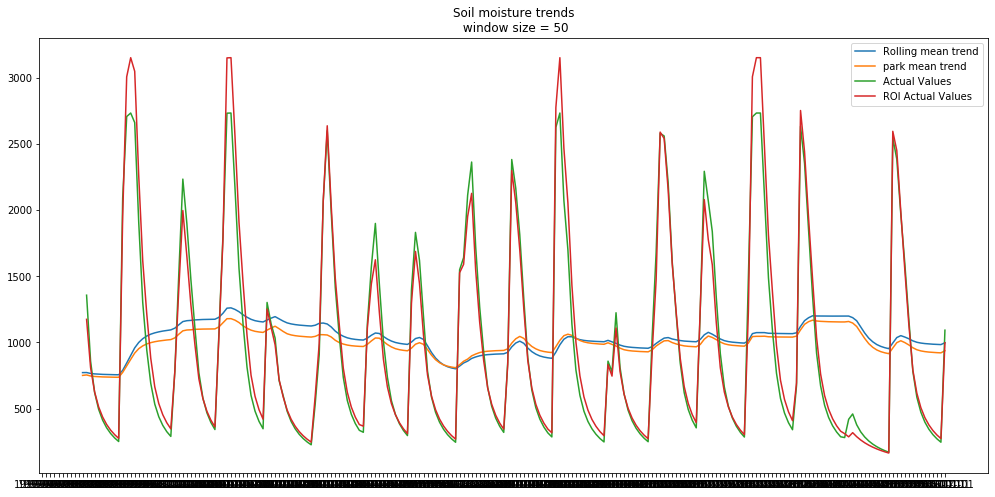

In [48]:
moving_average(park_data.soil,ROI_data.soil,"Soil moisture trends",50)

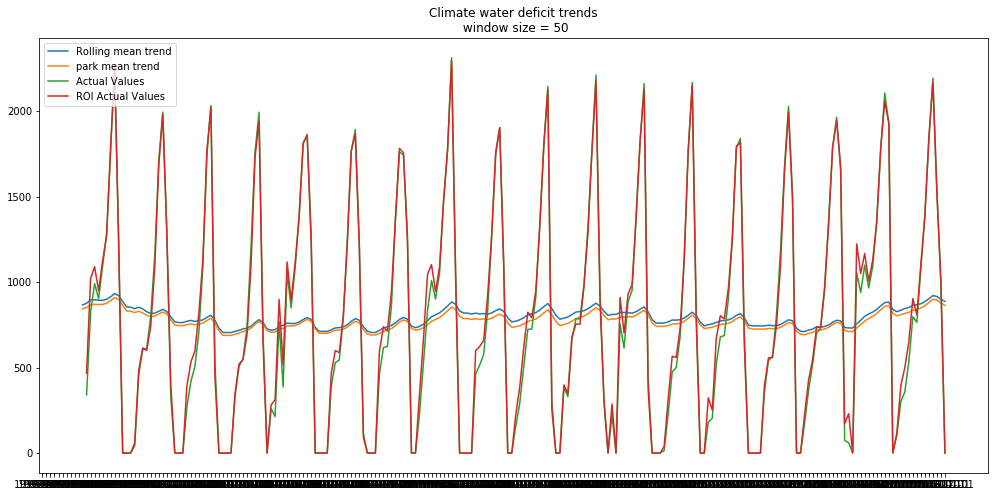

In [49]:
moving_average(park_data.water_def,ROI_data.water_def,"Climate water deficit trends",50)

# The Elephant in the Room

While analysing the animal counting data in the region of interest, we noted that there had been a general increase in elephant sightings over the priod of time the data was collected. An increase in the number of elephants corresponded to a decrease in the number of species with the same feeding habits sighted.

In [36]:
def game_counts(game_animal_1, game_animal_2):
    width = 0.6
    x = np.arange(len(game_count.Year))

    fig, ax = plt.subplots(figsize=(25,10))

    rects1 = ax.bar(x - width/3, game_animal_1, width, label=game_animal_1.name)
    rects2 = ax.bar(x + width/3, game_animal_2, width, label=game_animal_2.name)


    ax.set_ylabel('Animal Counts')
    ax.set_xlabel('Time Period')
    ax.set_title('Year')
    ax.set_xticks(x)
    ax.legend()

    fig.tight_layout()

    plt.show()

The sighting of elephants compared to Buffalo sightings

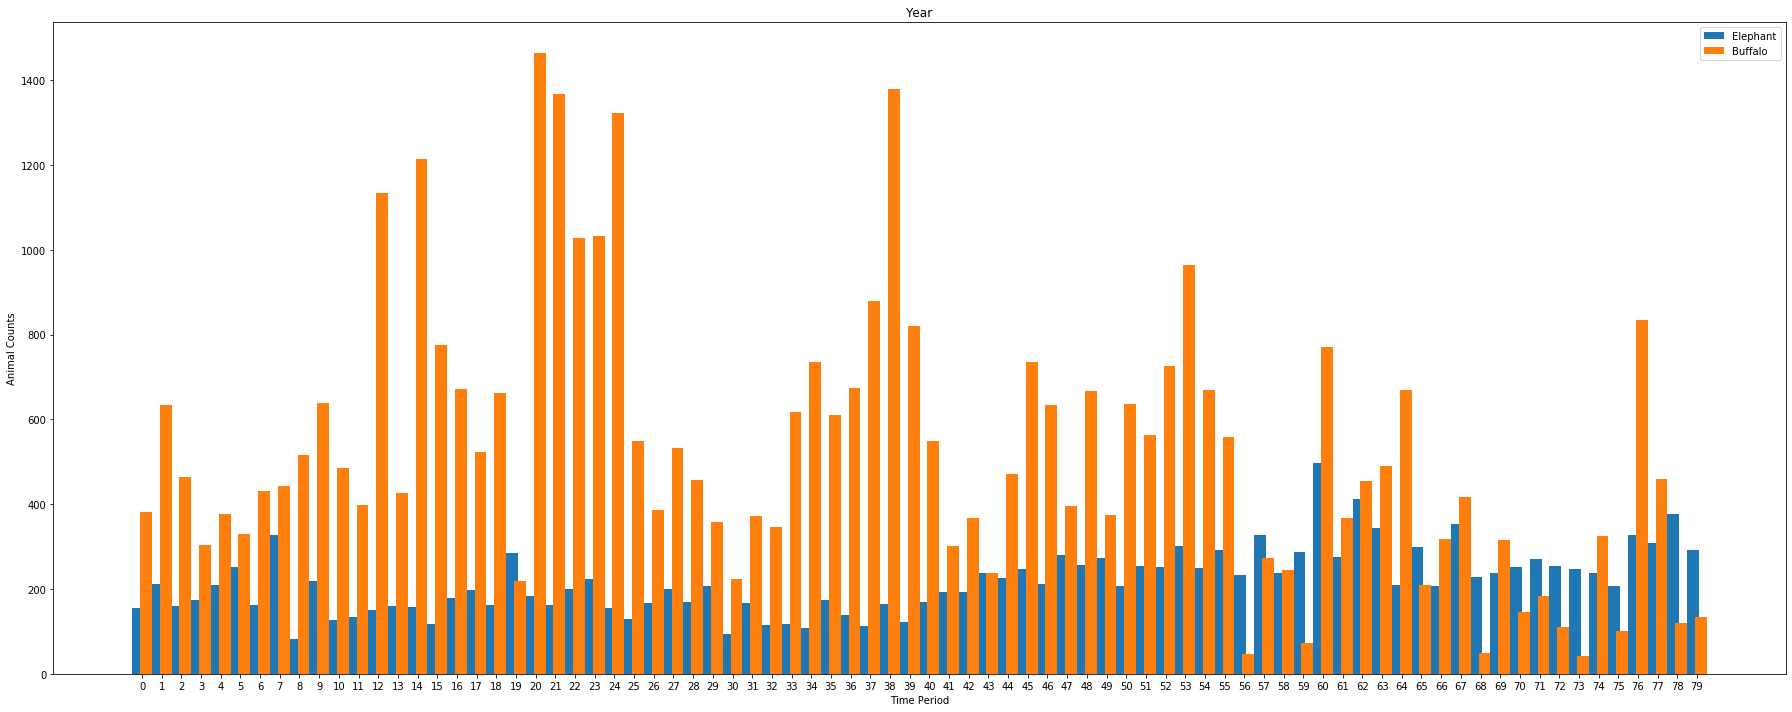

In [37]:
game_counts(game_count.Elephant, game_count.Buffalo)

The sighting of elephants compared to Zebra sightings

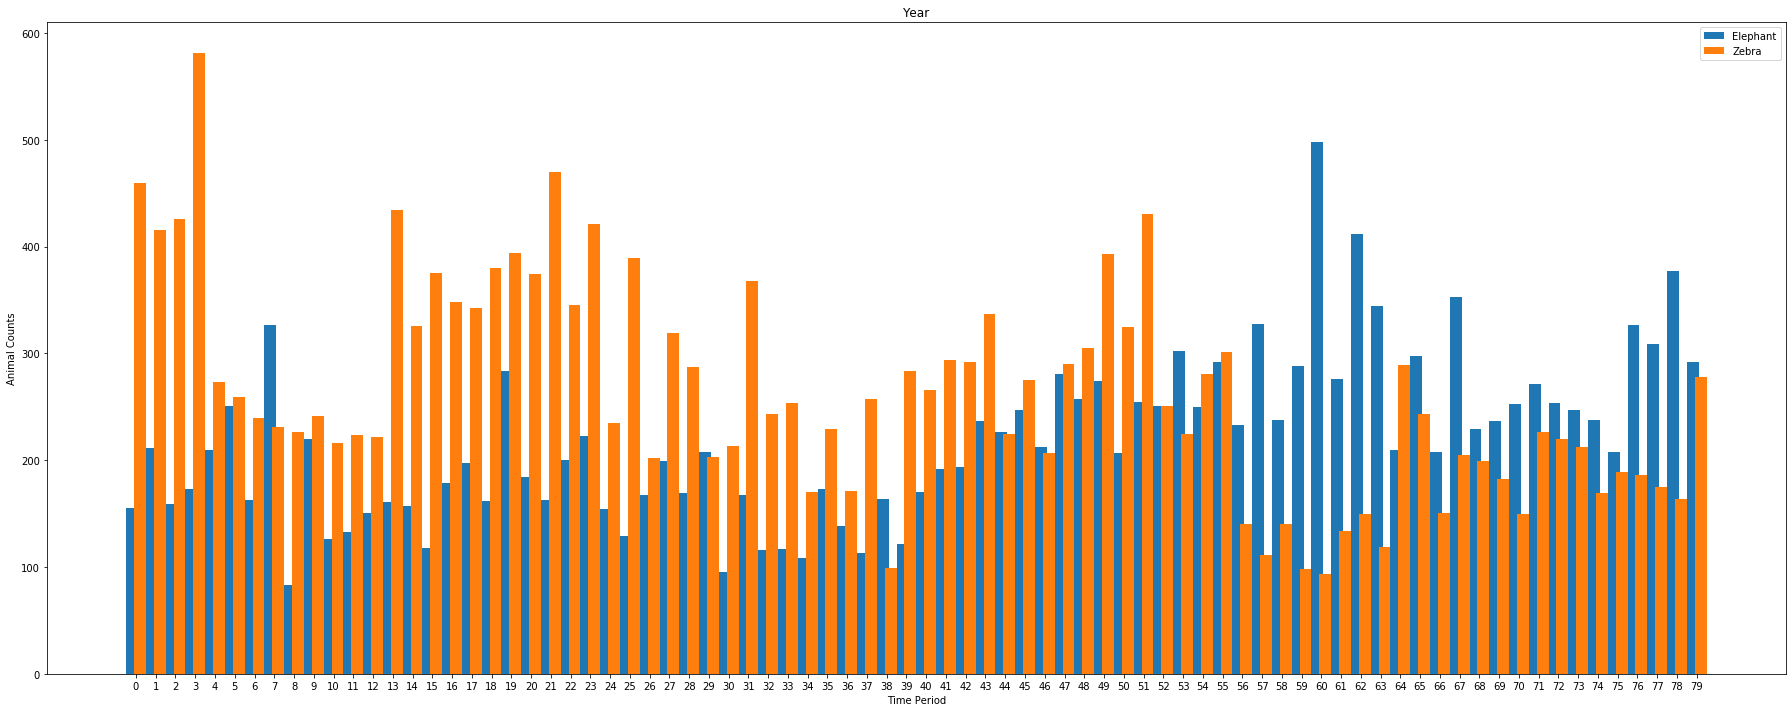

In [38]:
game_counts(game_count.Elephant, game_count.Zebra)

The sighting of elephants compared to Eland sightings

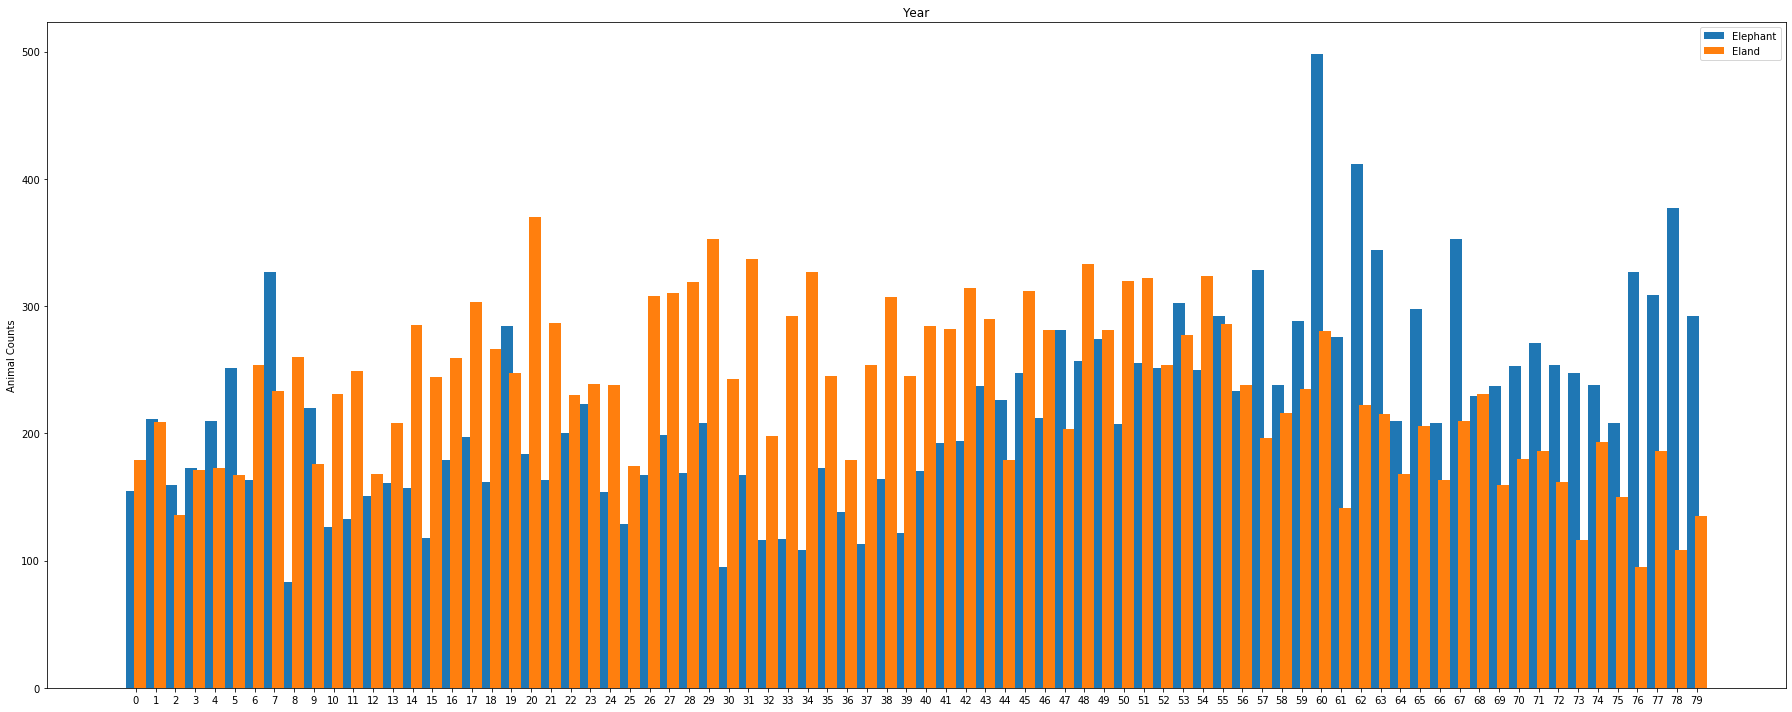

In [17]:
game_counts(game_count.Elephant, game_count.Eland)

The sighting of elephants compared to Waterbuck sightings

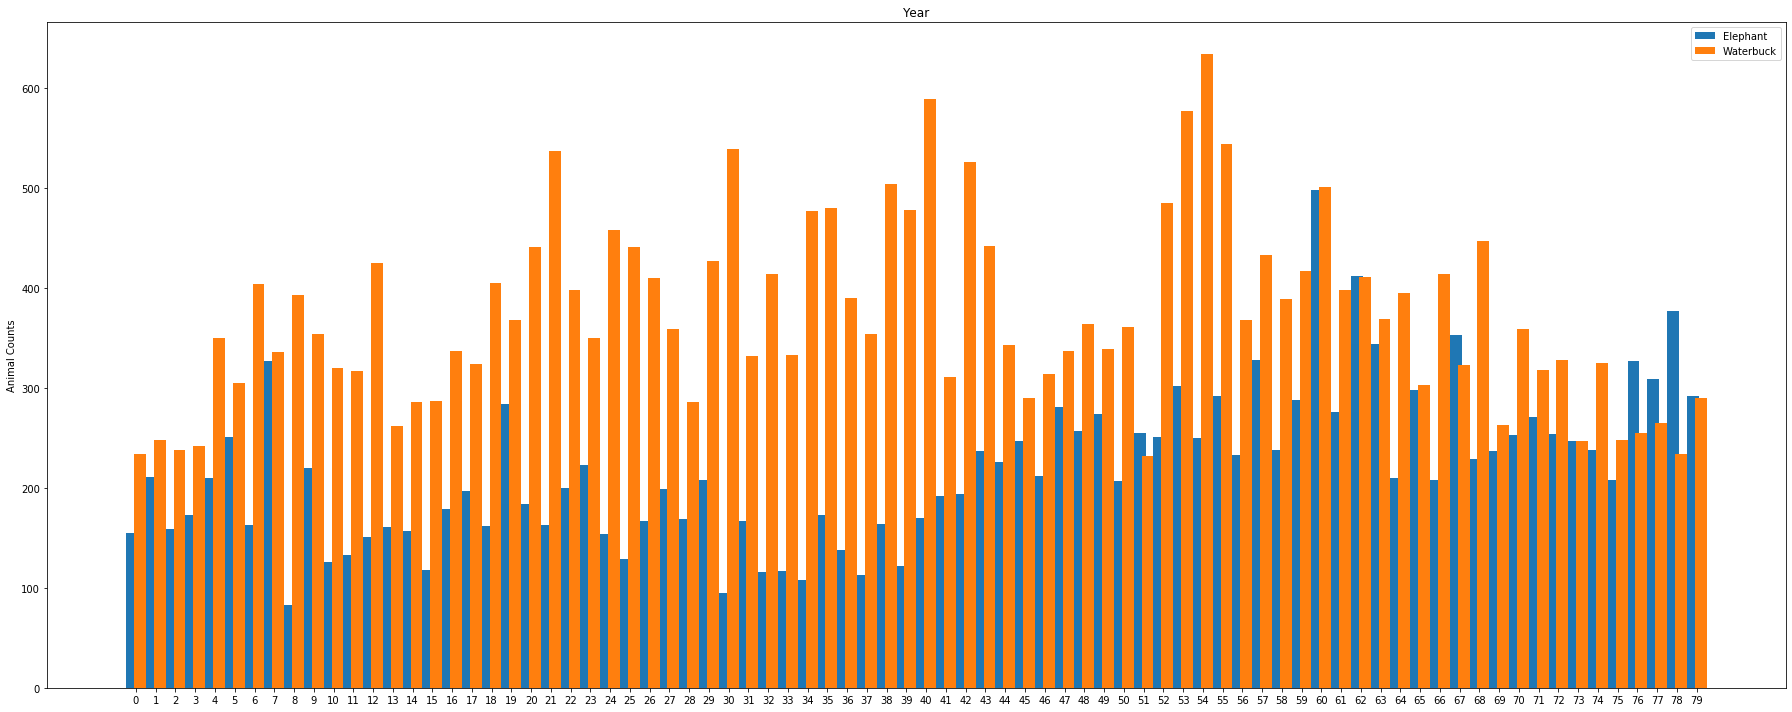

In [18]:
game_counts(game_count.Elephant, game_count.Waterbuck)

The sighting of elephants compared to Kudu sightings

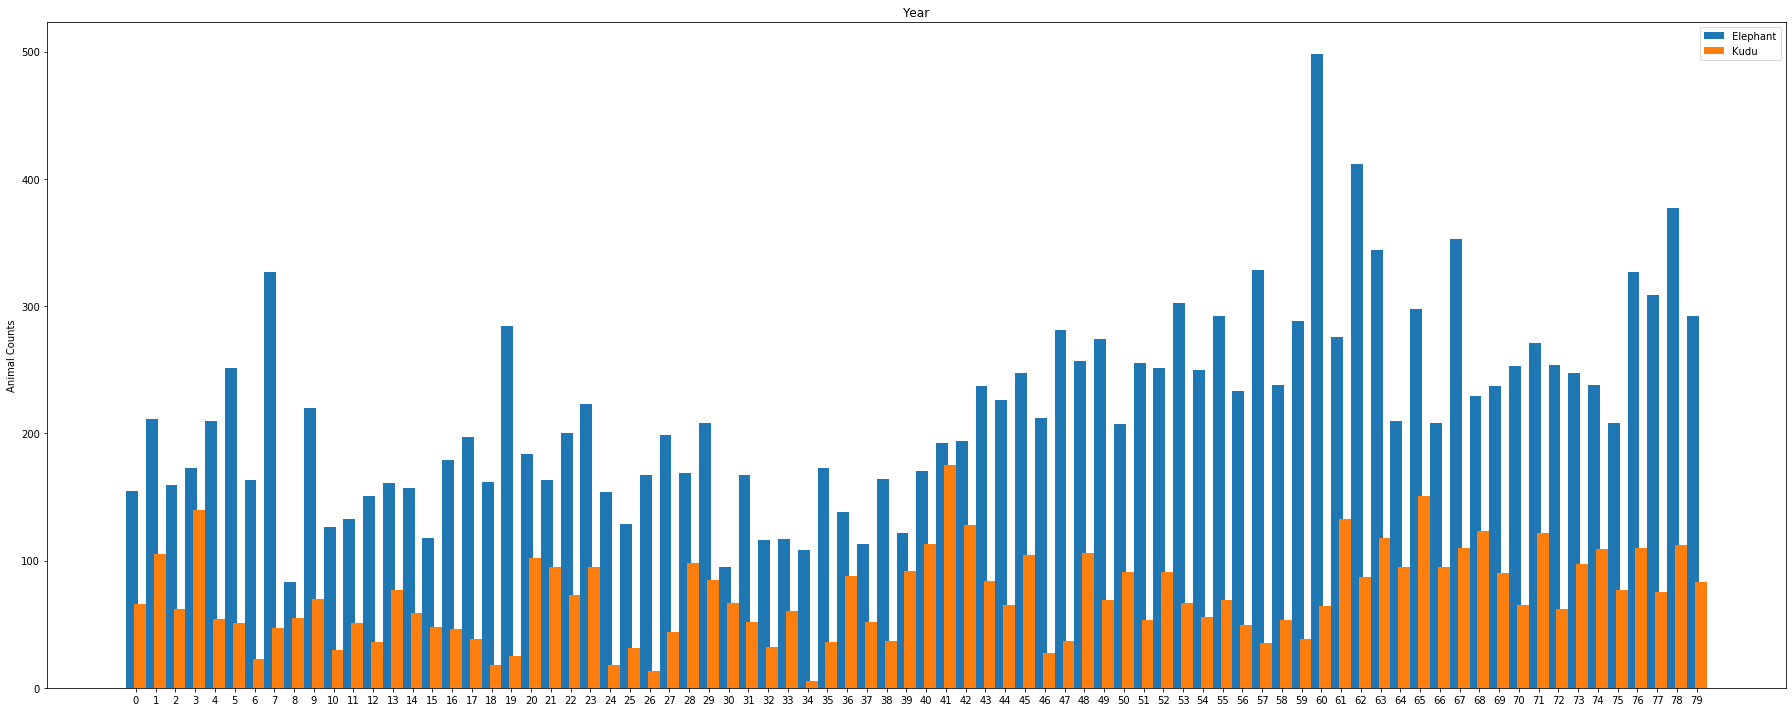

In [19]:
game_counts(game_count.Elephant, game_count.Kudu)

The trend however does not seem to affect carnivores and omnivores where the pattern of increasing elephant sightings leading to decreased sightings for other species.

The sighting of elephants compared to Wild dog sightings

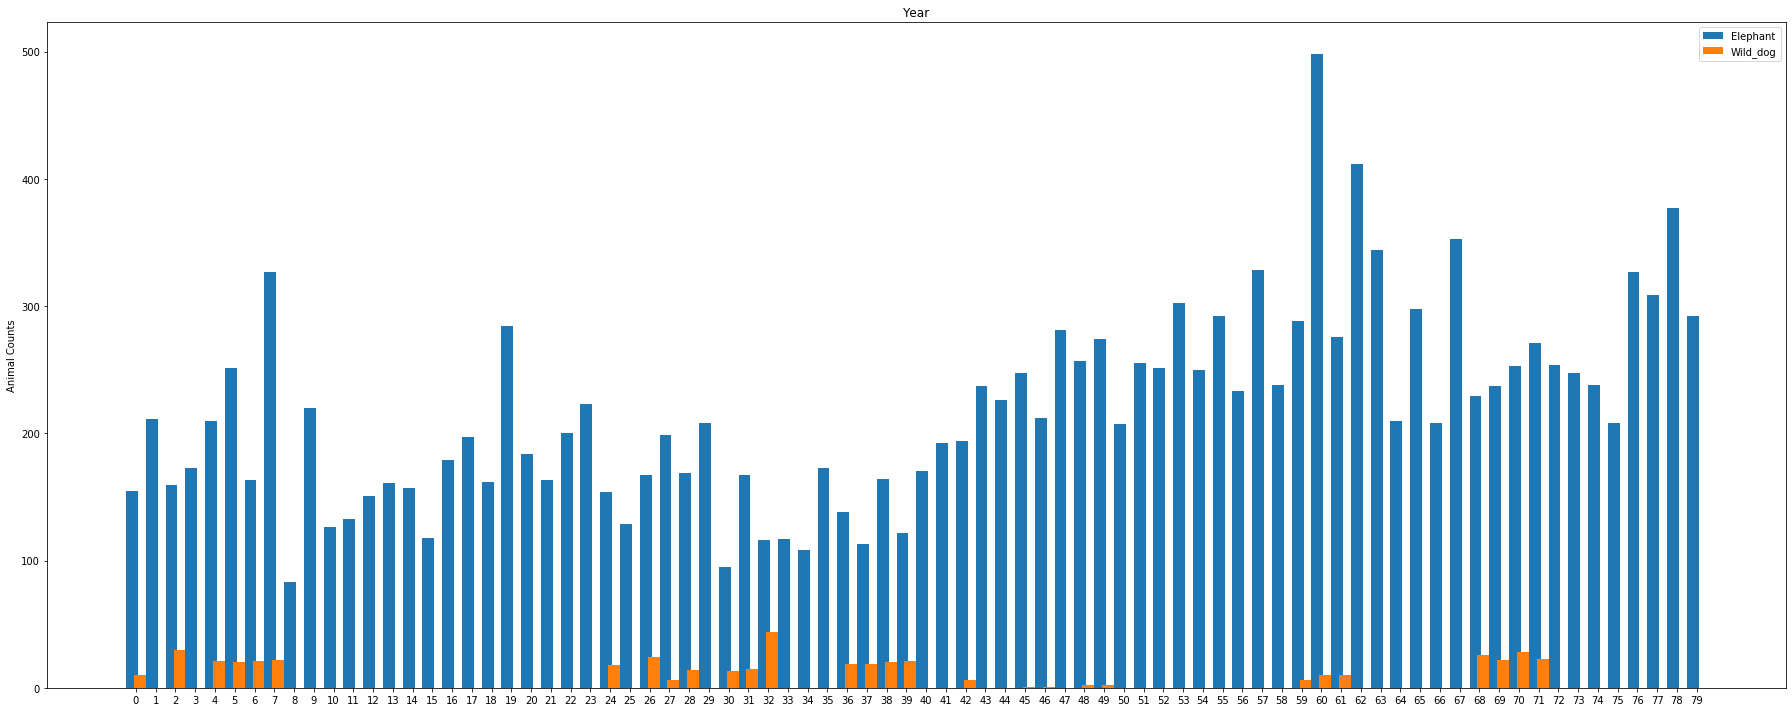

In [21]:
game_counts(game_count.Elephant, game_count.Wild_dog)

The sighting of elephants compared to Lion sightings

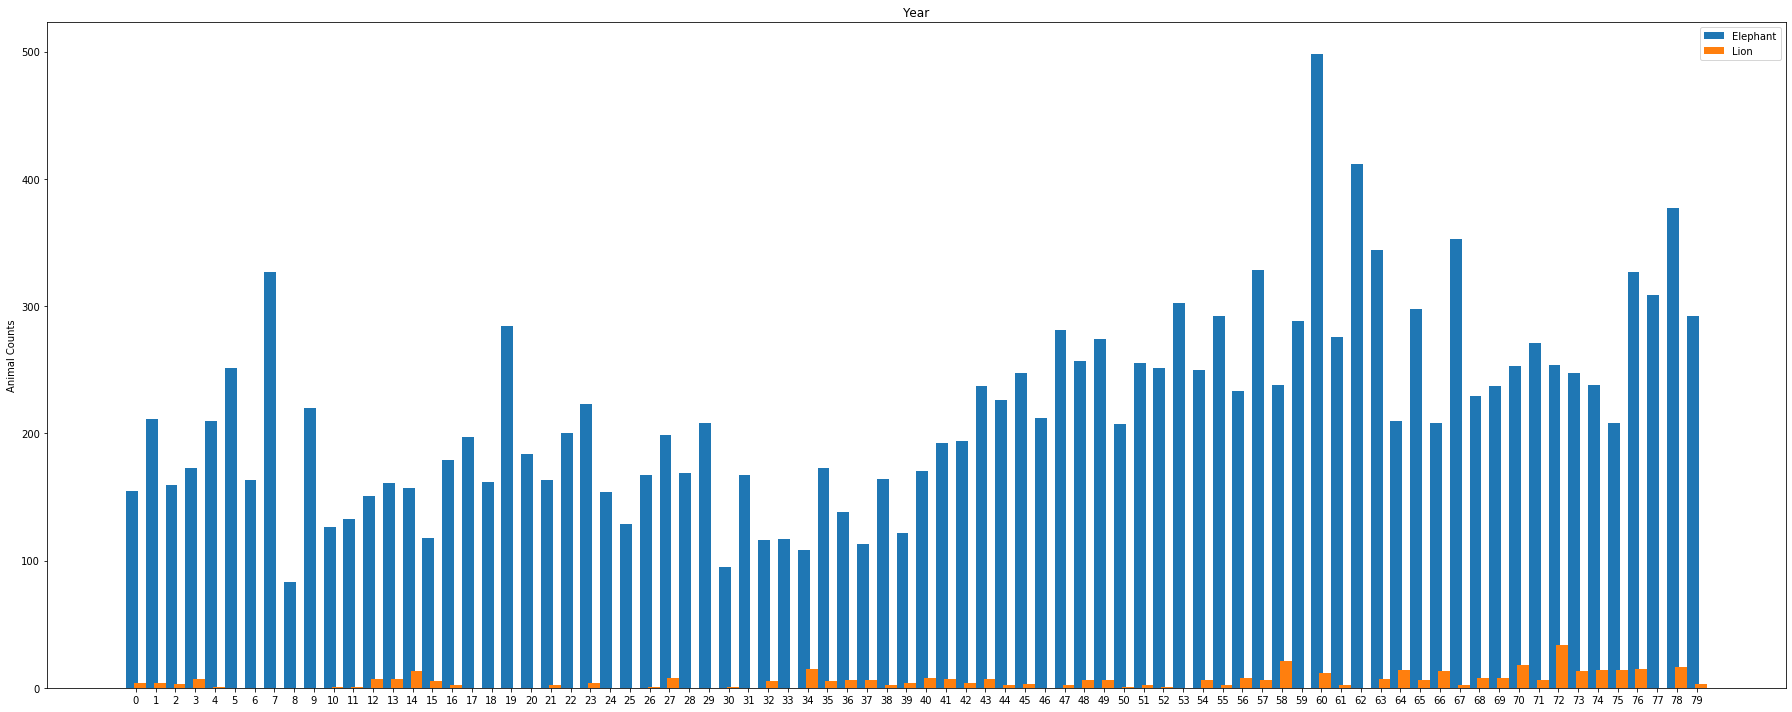

In [22]:
game_counts(game_count.Elephant, game_count.Lion)

The sighting of elephants compared to Warthog sightings

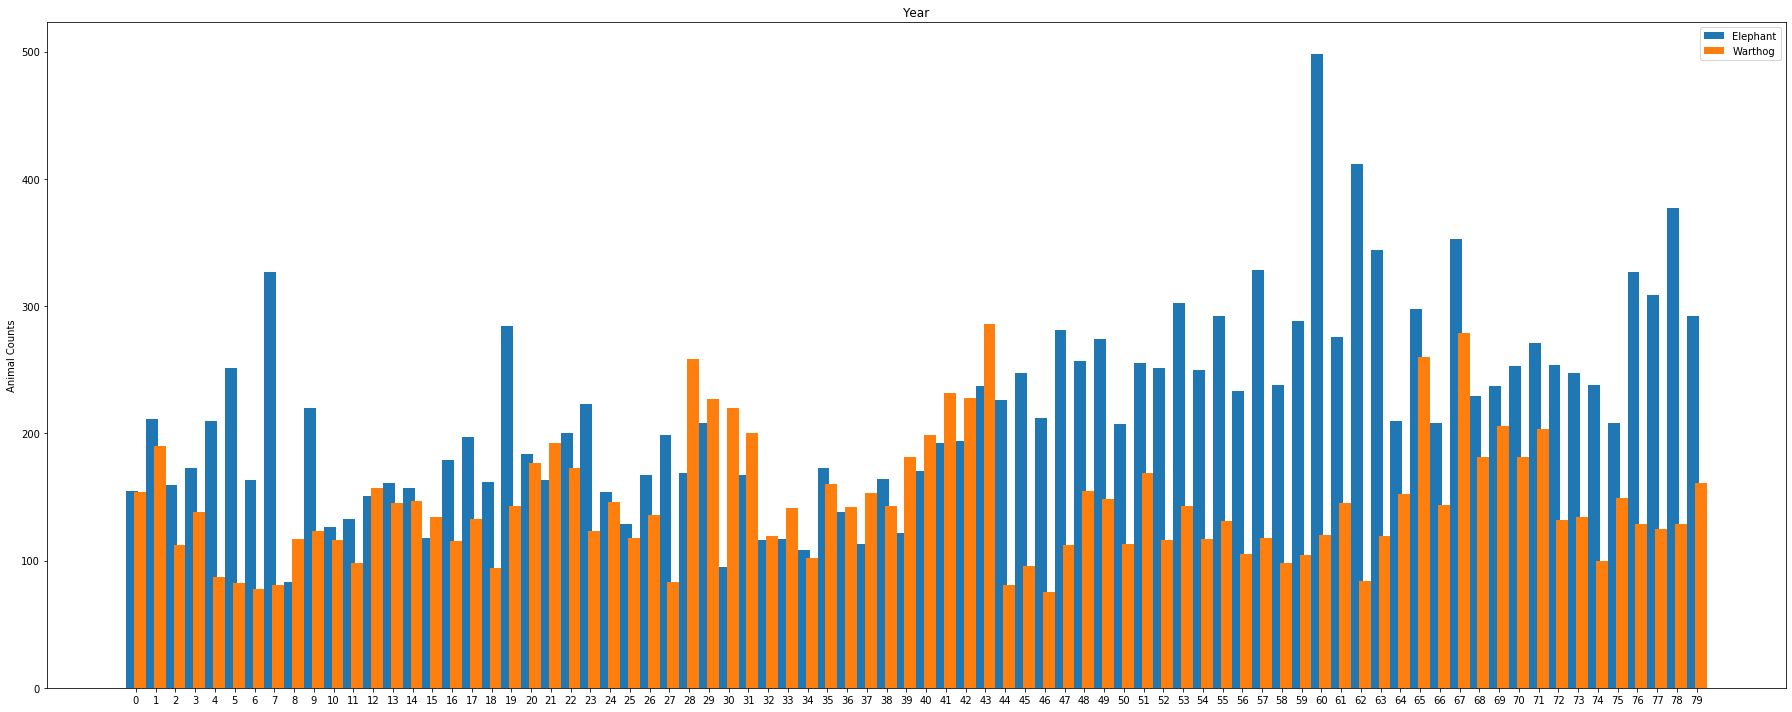

In [23]:
game_counts(game_count.Elephant, game_count.Warthog)

The sighting of elephants compared to Baboon sightings

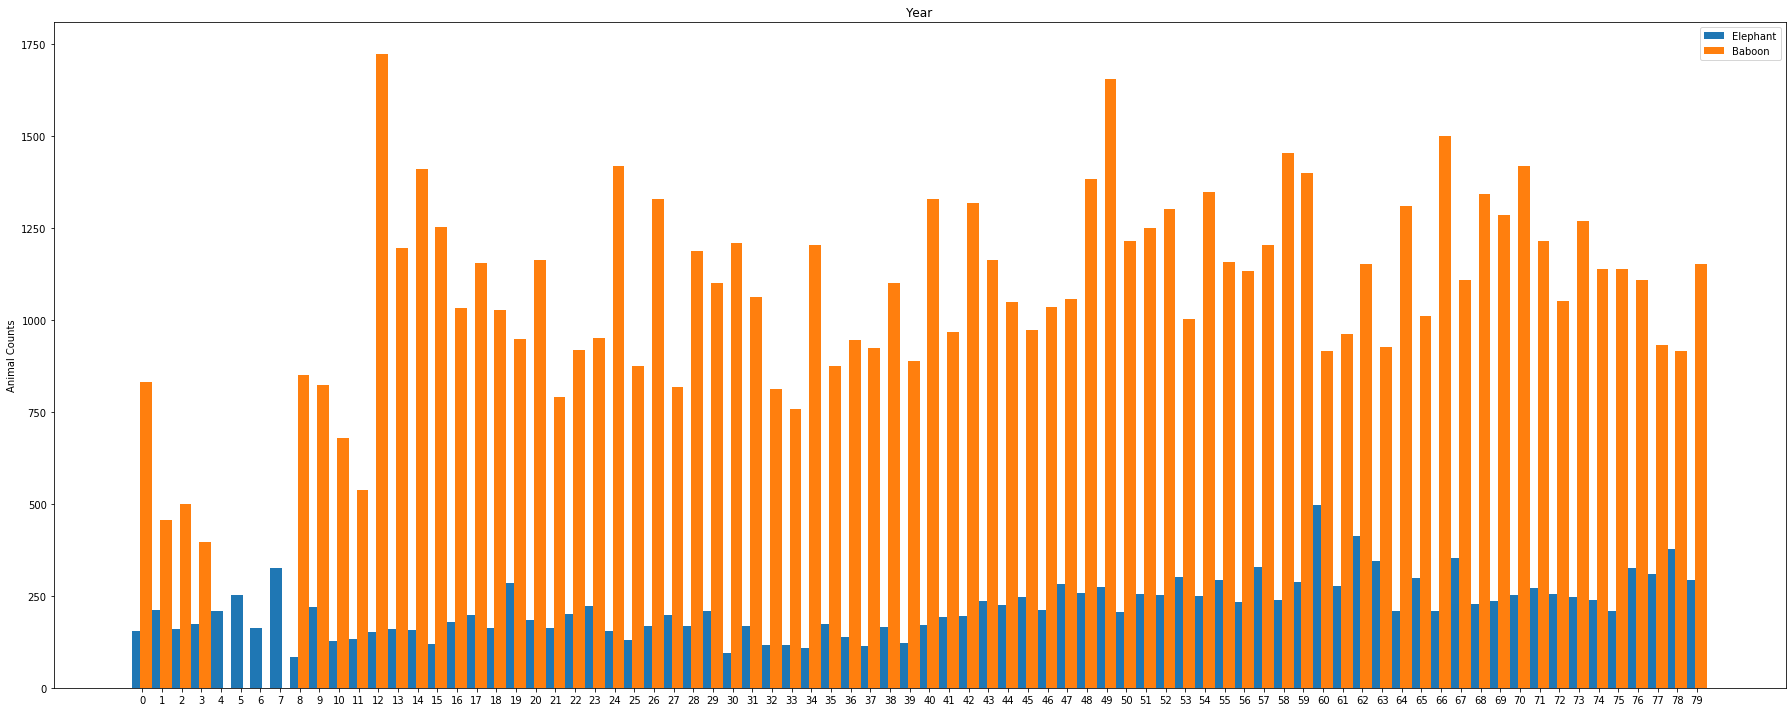

In [24]:
game_counts(game_count.Elephant, game_count.Baboon)

# Conclusion
We conclude that the presence of elephants in the ROI might be leading to the decrease in sightings of other animals at the area. This may be attributed to competition for grazing and or watering areas.